# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).Use BoW, TF-IDF, Avg-Word2Vec,TF-IDF-Word2Vec to vectorise the reviews. 
Apply K-means Algorithm for Amazon fine food Reviews
Find right k by elbow or knee method. Apply AgglomerativeClustering, Apply DBScan Algorithm,Find the best ‘Eps’ using the elbow-knee method,Representing Reviews in a cluster as a word cloud


<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.





# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.cluster import DBSCAN


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:11<00:00, 438.93it/s]


In [23]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
pd.options.display.width = None

final['Summary'].head(5000)


2546                                        thirty bucks?
2547                                         Flies Begone
1145                       WOW Make your own 'slickers' !
1146                                        Great Product
2942                                          Good stuff!
2941                          Premium Quality Dog Food!!!
1071                                        Cats love it!
2187                 Nice, Big Pieces & Big Almond Flavor
4695                  A Summer Treat Fat Free, Guilt Free
2068    Don't buy this product unless you are looking ...
2069                                        Little Flavor
2806                                 A Staple in my house
2805                       A favorite quick meal solution
4099    Best Hot Sauce and Taco Sauce Available In Ame...
4096                               Pico Pica ... the BEST
4097                                   This is the stuff!
4098    What everyone is saying here about Pico Pica i...
1332          

In [25]:
# printing some random reviews
sent_0 = final['Summary'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Summary'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Summary'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Summary'].values[4900]
print(sent_4900)
print("="*50)



thirty bucks?
Best sour cream & onion chip I've had
Are We Reviewing Our Mistakes Or These Cookies?
caribou


In [26]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

thirty bucks?


In [27]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

thirty bucks?
Best sour cream & onion chip I've had
Are We Reviewing Our Mistakes Or These Cookies?
caribou


In [28]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"I've","i have",phrase)
    phrase = re.sub(r"Don't","do not",phrase)
    phrase = re.sub(r"It's","it is",phrase)
    phrase = re.sub(r"wouldn't","would not",phrase)
    phrase = re.sub(r"You'll","you will",phrase)
    phrase = re.sub(r"Doesn't","does not",phrase)
    phrase = re.sub(r"They're","they are",phrase)
    phrase = re.sub(r"That's","that is",phrase)
    phrase = re.sub(r"didn't","did not",phrase)
    phrase = re.sub(r"Doesn't","does not",phrase)
    phrase = re.sub(r"you're","you are",phrase)
    phrase = re.sub(r"That's","that is",phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [29]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Are We Reviewing Our Mistakes Or These Cookies?


In [30]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

thirty bucks?


In [31]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Are We Reviewing Our Mistakes Or These Cookies 


In [32]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [33]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews1 = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews1.append(sentance.strip())

100%|██████████| 4986/4986 [00:05<00:00, 970.11it/s] 


In [34]:
preprocessed_reviews1[1500]

'reviewing mistakes cookies'

# [4] Featurization

## [4.1] BAG OF WORDS

In [35]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [36]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [37]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [38]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [39]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('looking', 0.9958670139312744), ('others', 0.9952445030212402), ('recommended', 0.9950801134109497), ('overall', 0.994975209236145), ('likes', 0.9947472810745239), ('either', 0.9944906234741211), ('certainly', 0.9943563342094421), ('wanting', 0.9943377375602722), ('least', 0.9941763281822205), ('excellent', 0.994172215461731)]
[('fairly', 0.9993622303009033), ('dont', 0.9993348121643066), ('choice', 0.9993026256561279), ('popped', 0.9992945194244385), ('dinner', 0.9992868304252625), ('crisps', 0.9992811679840088), ('yes', 0.9992802739143372), ('tomatoes', 0.9992760419845581), ('awful', 0.9992610216140747), ('together', 0.9992534518241882)]


In [40]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [41]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 4986/4986 [00:27<00:00, 180.41it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [42]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [43]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


100%|██████████| 4986/4986 [02:23<00:00, 34.78it/s]


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [44]:
# Normalizing Data

# Data-preprocessing: Normalizing Data

from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(final_counts)
print(standardized_data_train.shape)

(4986, 12997)


In [45]:
# https://www.kaggle.com/vjchoudhary7/kmeans-clustering-in-customer-segmentation
# https://www.youtube.com/watch?v=TGad0nc-8gU
from sklearn.cluster import KMeans
k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i,init='k-means++',n_init=10, max_iter=300,tol=0.0001,precompute_distances='auto',verbose=0, random_state=42,n_jobs=-1)
    kmeans.fit(standardized_data_train)
    loss.append(kmeans.inertia_)
    
# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)
# save new clusters for chart

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.00011895 0.         ... 0.00021765 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.00011727 ... 0.00011588 0.         0.00016685]]


### Plotting a graph K vs  Inertia

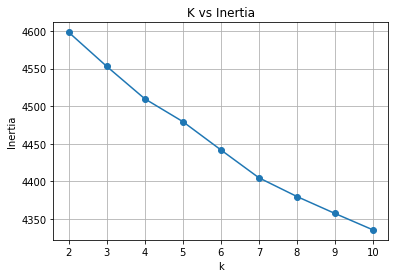

In [46]:
plt.plot(k_values,loss,marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title("K vs Inertia")
plt.grid()
plt.show()

In [47]:
kmeans = KMeans(n_clusters=5, init='k-means++',n_init=10, max_iter=300,tol=0.0001,precompute_distances='auto',verbose=0, random_state=42,n_jobs=-1)
kmeans.fit(standardized_data_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

### Getting all the Reviews in different clusters

In [48]:
reviews = preprocessed_reviews    
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif kmeans.labels_[i] == 3:
        cluster4.append(reviews[i])
    else :
        cluster5.append(reviews[i]) 
        
# Number of reviews in different clusters
print("\nNo. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))


No. of reviews in Cluster-1 :  1487

No. of reviews in Cluster-2 :  309

No. of reviews in Cluster-3 :  412

No. of reviews in Cluster-4 :  1958

No. of reviews in Cluster-5 :  820


### Reading Reviews Manually:

In [49]:
# Three Reviews of cluster 1
reviews=[]
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    reviews.append(cluster1[i])
    count +=1
print(reviews)

Review-1 : 
 shipped day ordered arrived within days live opposite coast made order arrived nicely packaged price got lbs oz biscotti weighed kitchen scale cut big pieces add shipping handling comes little per piece approximately local bakery charges per biscotti guess going price homemade biscotti days flavor almondy hardness perfect biscotti hard crunchy not hard could not eat without dunking biscotti biscotti eaten dunked coffee tea cocoa dunked mine chai tea tastes great biscotti not fall apart dunked like almond flavor wish came anise flavor favorite biscotti flavor

Review-2 : 
 description product disceptive product represented powder not powder granule nothing shredded coconut not even dissolve high speed commercial blender unless using product manufacture dark chocolate coated coconut patty useless intention use additive healthy shake ended ruining shake resort chewing undissolved tasteless coconut pieces rather drinking shake additionally way product packaged no protective ca

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>



Word Cloud for Important features


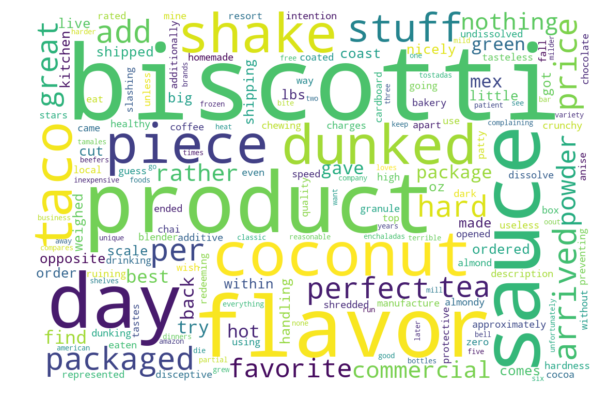

In [50]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster1), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(10,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [51]:
# Three Reviews of cluster 2
reviews=[]
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    reviews.append(cluster2[i])
    count +=1
print(reviews)

Review-1 : 
 though coffee expensive compared regular store bought huge fan coffee usually tears stomach tea drinker years coffee low acidic level handle aroma enticing bag lasted long time fan beans versus grounds another plus prompt packaging ensured coffee stayed fresh intact

Review-2 : 
 husband took vacation costa rica wonderful time whole time drank britt dark roast loved taste no bitter taste plus normally drink decaf noticed britt regular dark roast not bother not order decaf anymore enjoy regular order line find best tasting coffee ever thanks growing best coffee beans world

Review-3 : 
 coffee delicious full bodied leaves great almost chocolaty taste dad told trip costa rica

['though coffee expensive compared regular store bought huge fan coffee usually tears stomach tea drinker years coffee low acidic level handle aroma enticing bag lasted long time fan beans versus grounds another plus prompt packaging ensured coffee stayed fresh intact', 'husband took vacation costa ric



Word Cloud for Important features


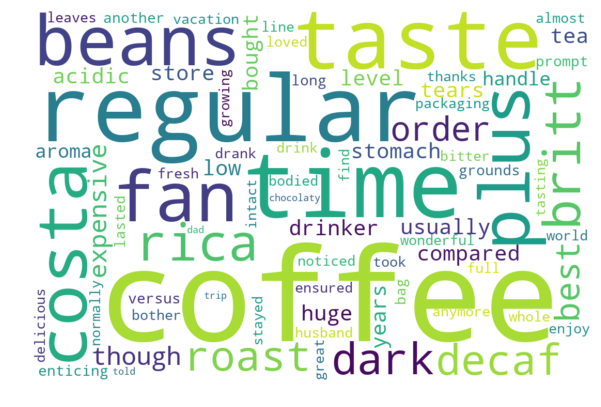

In [52]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster2), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(10,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [53]:
# Three Reviews of cluster 3
reviews=[]
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    reviews.append(cluster3[i])
    count +=1
print(reviews)

Review-1 : 
 tasted snack local pub found tasty much better chips mixes told sold sam club wegman per container bought utz pack piece different taste texture could not ask delicious snack better price thank utz

Review-2 : 
 found tubs costco dismayed discover no longer carrying buy amazon satisfied snacks tasty not salty offers variety chips mix blend nicely

Review-3 : 
 soy crisps excellent choice snacking grams protein serving much better potato chips snack foods great flavor enough salt leave feeling satisfied nutritionally snackwise grandchildren know crisps offered house snacking highly recommend

['tasted snack local pub found tasty much better chips mixes told sold sam club wegman per container bought utz pack piece different taste texture could not ask delicious snack better price thank utz', 'found tubs costco dismayed discover no longer carrying buy amazon satisfied snacks tasty not salty offers variety chips mix blend nicely', 'soy crisps excellent choice snacking grams pr



Word Cloud for Important features


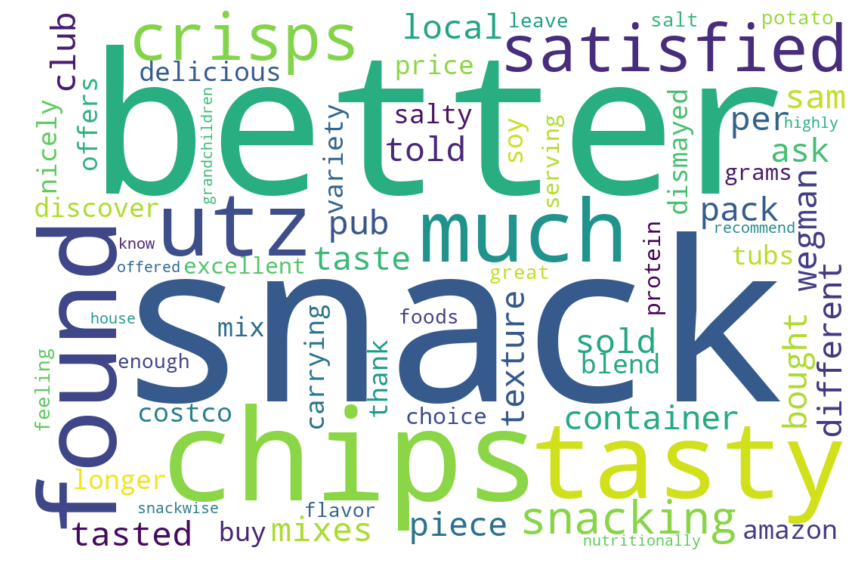

In [54]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster3), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(15,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [55]:
# Three Reviews of cluster 4
reviews=[]
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster4[i]))
    reviews.append(cluster4[i])
    count +=1

Review-1 : 
 product available victor traps unreal course total fly genocide pretty stinky right nearby

Review-2 : 
 received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors

Review-3 : 
 really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs





Word Cloud for Important features


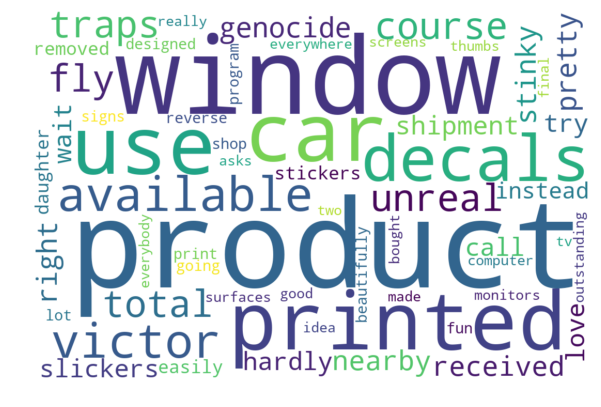

In [56]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster4), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(10,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [57]:
# Normalizing Data

# Data-preprocessing: Normalizing Data

from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(final_bigram_counts)
print(standardized_data_train.shape)

(4986, 3144)


In [58]:
# https://www.kaggle.com/vjchoudhary7/kmeans-clustering-in-customer-segmentation
# https://www.youtube.com/watch?v=TGad0nc-8gU
from sklearn.cluster import KMeans
k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i,init='k-means++',n_init=10, max_iter=300,tol=0.0001,precompute_distances='auto',verbose=0, random_state=42,n_jobs=-1)
    kmeans.fit(standardized_data_train)
    loss.append(kmeans.inertia_)  #it is sum of intra cluster distances it should be very low
    
# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)
# save new clusters for chart

[[0.         0.00191496 0.00191496 ... 0.00356972 0.00072498 0.        ]
 [0.         0.00413979 0.00029988 ... 0.         0.         0.00036898]
 [0.00022251 0.00303545 0.00157067 ... 0.00386039 0.         0.00043248]
 ...
 [0.         0.00291997 0.         ... 0.00498342 0.00080763 0.00058298]
 [0.00042128 0.00564237 0.00133835 ... 0.00393494 0.00037106 0.00033818]
 [0.         0.00296406 0.         ... 0.00144121 0.00033533 0.00030402]]


### Plotting a graph K vs  Inertia

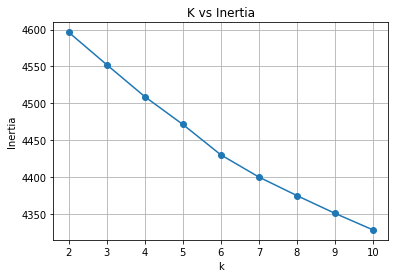

In [59]:
plt.plot(k_values,loss,marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title("K vs Inertia")
plt.grid()
plt.show()

In [60]:
kmeans = KMeans(n_clusters=5, init='k-means++',n_init=10, max_iter=300,tol=0.0001,precompute_distances='auto',verbose=0, random_state=42,n_jobs=-1)
kmeans.fit(standardized_data_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

### Getting all the Reviews in different clusters

In [61]:
reviews = preprocessed_reviews    
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif kmeans.labels_[i] == 3:
        cluster4.append(reviews[i])
    else :
        cluster5.append(reviews[i]) 
        
# Number of reviews in different clusters
print("\nNo. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))


No. of reviews in Cluster-1 :  427

No. of reviews in Cluster-2 :  2208

No. of reviews in Cluster-3 :  1750

No. of reviews in Cluster-4 :  304

No. of reviews in Cluster-5 :  297


### Reading Reviews Manually:

In [62]:
# Three Reviews of cluster 1
reviews=[]
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    reviews.append(cluster1[i])
    count +=1
print(reviews)

Review-1 : 
 tasted snack local pub found tasty much better chips mixes told sold sam club wegman per container bought utz pack piece different taste texture could not ask delicious snack better price thank utz

Review-2 : 
 found tubs costco dismayed discover no longer carrying buy amazon satisfied snacks tasty not salty offers variety chips mix blend nicely

Review-3 : 
 soy crisps excellent choice snacking grams protein serving much better potato chips snack foods great flavor enough salt leave feeling satisfied nutritionally snackwise grandchildren know crisps offered house snacking highly recommend

['tasted snack local pub found tasty much better chips mixes told sold sam club wegman per container bought utz pack piece different taste texture could not ask delicious snack better price thank utz', 'found tubs costco dismayed discover no longer carrying buy amazon satisfied snacks tasty not salty offers variety chips mix blend nicely', 'soy crisps excellent choice snacking grams pr

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>



Word Cloud for Important features


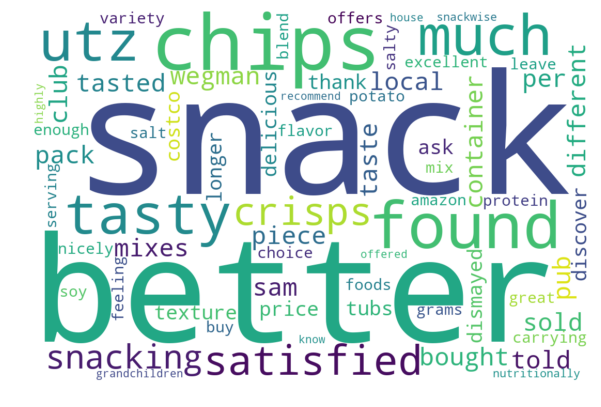

In [63]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster1), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(10,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [64]:
# Three Reviews of cluster 2
reviews=[]
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    reviews.append(cluster2[i])
    count +=1
print(reviews)

Review-1 : 
 product available victor traps unreal course total fly genocide pretty stinky right nearby

Review-2 : 
 received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors

Review-3 : 
 really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs

['product available victor traps unreal course total fly genocide pretty stinky right nearby', 'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors', 'really good idea final product outstanding use decals car window everybody asks bought decals made two



Word Cloud for Important features


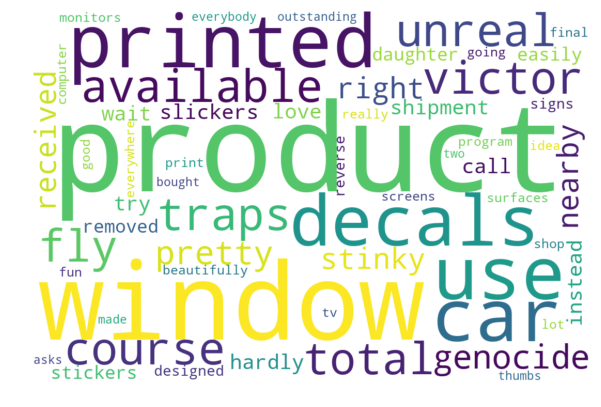

In [65]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster2), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(10,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [66]:
# Three Reviews of cluster 3
reviews=[]
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    reviews.append(cluster3[i])
    count +=1
print(reviews)

Review-1 : 
 used victor fly bait seasons ca not beat great product

Review-2 : 
 shipped day ordered arrived within days live opposite coast made order arrived nicely packaged price got lbs oz biscotti weighed kitchen scale cut big pieces add shipping handling comes little per piece approximately local bakery charges per biscotti guess going price homemade biscotti days flavor almondy hardness perfect biscotti hard crunchy not hard could not eat without dunking biscotti biscotti eaten dunked coffee tea cocoa dunked mine chai tea tastes great biscotti not fall apart dunked like almond flavor wish came anise flavor favorite biscotti flavor

Review-3 : 
 mix probably not something would want use everyday new enough different enough something special add summertime recipe want reward something fun fruity fill bill quickly easily no aftertaste often associated diet drinks highly recommend

['used victor fly bait seasons ca not beat great product', 'shipped day ordered arrived within days l



Word Cloud for Important features


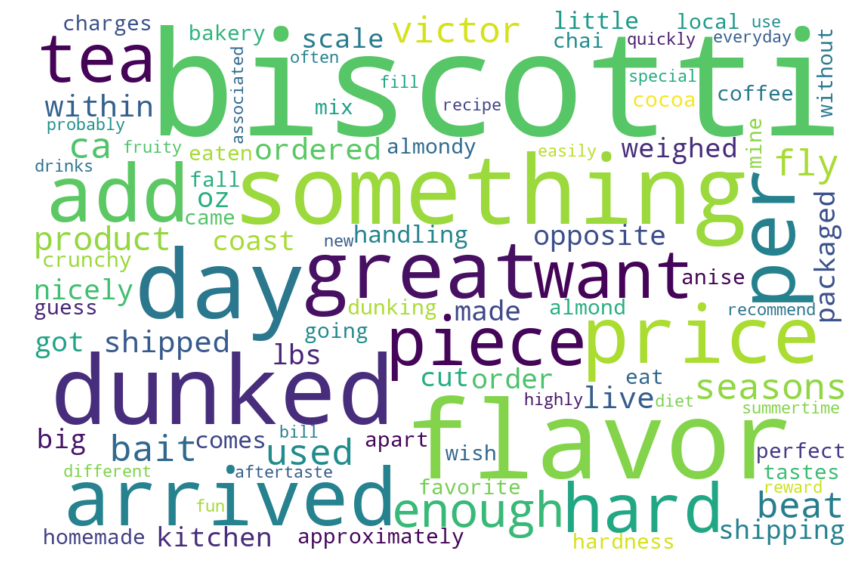

In [67]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster3), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(15,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [68]:
# Three Reviews of cluster 4
reviews=[]
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster4[i]))
    reviews.append(cluster4[i])
    count +=1

Review-1 : 
 though coffee expensive compared regular store bought huge fan coffee usually tears stomach tea drinker years coffee low acidic level handle aroma enticing bag lasted long time fan beans versus grounds another plus prompt packaging ensured coffee stayed fresh intact

Review-2 : 
 husband took vacation costa rica wonderful time whole time drank britt dark roast loved taste no bitter taste plus normally drink decaf noticed britt regular dark roast not bother not order decaf anymore enjoy regular order line find best tasting coffee ever thanks growing best coffee beans world

Review-3 : 
 coffee delicious full bodied leaves great almost chocolaty taste dad told trip costa rica





Word Cloud for Important features


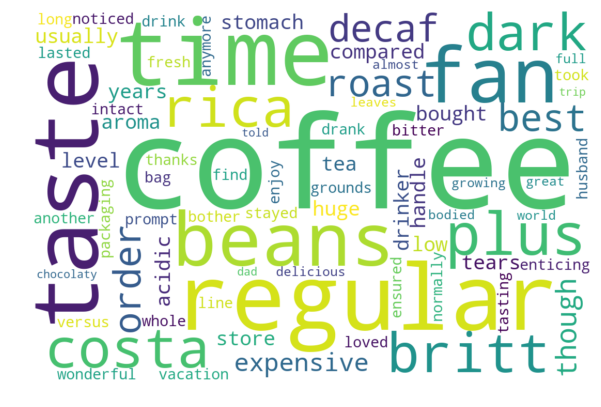

In [69]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster4), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(10,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [70]:
# Data-preprocessing: Normalizing Data
from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(final_tf_idf)
print(standardized_data_train.shape)

(4986, 3144)


In [71]:
# https://www.kaggle.com/vjchoudhary7/kmeans-clustering-in-customer-segmentation
#https://www.youtube.com/watch?v=TGad0nc-8gU
from sklearn.cluster import KMeans
k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i,init='k-means++',n_init=10, max_iter=300,tol=0.0001,precompute_distances='auto',verbose=0, random_state=42,n_jobs=-1)
    kmeans.fit(standardized_data_train)
    loss.append(kmeans.inertia_)
    
# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)
# save new clusters for chart

[[0.         0.00241862 0.0022158  ... 0.00349484 0.         0.        ]
 [0.         0.00273084 0.         ... 0.00140136 0.00043767 0.00039804]
 [0.00045588 0.00945836 0.00586433 ... 0.00115314 0.         0.        ]
 ...
 [0.         0.00115301 0.         ... 0.         0.         0.        ]
 [0.         0.00324113 0.00100039 ... 0.00382914 0.00095606 0.00117306]
 [0.         0.00549379 0.00136805 ... 0.00821344 0.         0.        ]]


### Plotting a graph K vs  Inertia

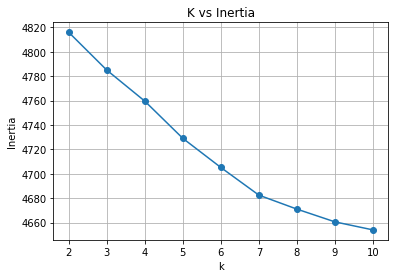

In [72]:
plt.plot(k_values,loss,marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title("K vs Inertia")
plt.grid()
plt.show()

In [73]:
kmeans = KMeans(n_clusters=5, init='k-means++',n_init=10, max_iter=300,tol=0.0001,precompute_distances='auto',verbose=0, random_state=42,n_jobs=-1)
kmeans.fit(standardized_data_train)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

## Getting all the Reviews in different clusters

In [74]:
reviews = preprocessed_reviews
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster3.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster4.append(reviews[i])
    else :
        cluster5.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))


No. of reviews in Cluster-1 :  3379

No. of reviews in Cluster-2 :  570

No. of reviews in Cluster-3 :  0

No. of reviews in Cluster-4 :  0

No. of reviews in Cluster-5 :  1037


### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

In [75]:
#Reading Reviews Manually

# Three Reviews of cluster 1
reviews=[]
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    reviews.append(cluster1[i])
    count +=1
print(reviews)

Review-1 : 
 product available victor traps unreal course total fly genocide pretty stinky right nearby

Review-2 : 
 used victor fly bait seasons ca not beat great product

Review-3 : 
 received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors

['product available victor traps unreal course total fly genocide pretty stinky right nearby', 'used victor fly bait seasons ca not beat great product', 'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors']




Word Cloud for Important features


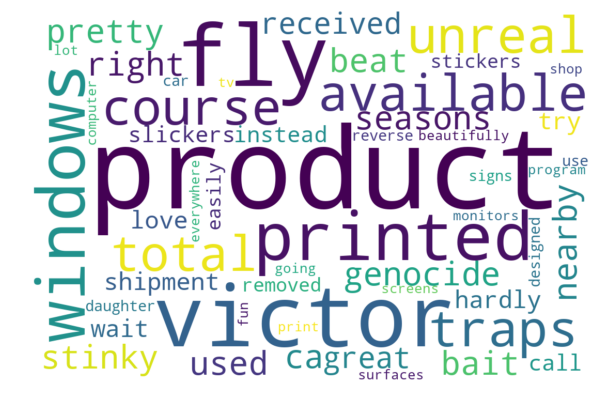

In [76]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster1), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(10,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [77]:
# Three Reviews of cluster 2
reviews=[]
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    reviews.append(cluster2[i])
    count +=1
print(reviews)

Review-1 : 
 though coffee expensive compared regular store bought huge fan coffee usually tears stomach tea drinker years coffee low acidic level handle aroma enticing bag lasted long time fan beans versus grounds another plus prompt packaging ensured coffee stayed fresh intact

Review-2 : 
 scotties full hot spots used within week hot spots gone smell kinda strong not bad tolerablel

Review-3 : 
 husband took vacation costa rica wonderful time whole time drank britt dark roast loved taste no bitter taste plus normally drink decaf noticed britt regular dark roast not bother not order decaf anymore enjoy regular order line find best tasting coffee ever thanks growing best coffee beans world

['though coffee expensive compared regular store bought huge fan coffee usually tears stomach tea drinker years coffee low acidic level handle aroma enticing bag lasted long time fan beans versus grounds another plus prompt packaging ensured coffee stayed fresh intact', 'scotties full hot spots use



Word Cloud for Important features


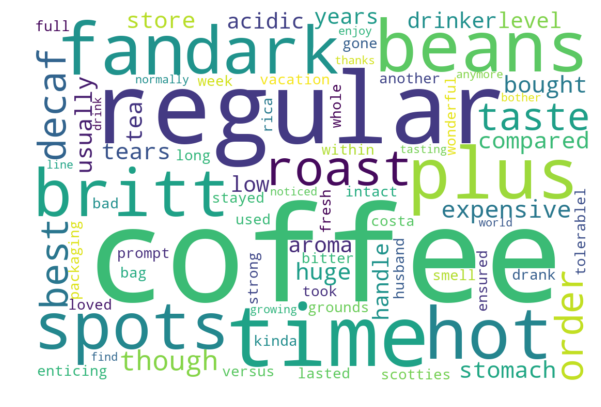

In [78]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster2), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(10,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [79]:
# Three Reviews of cluster 5
reviews=[]
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster5[i]))
    reviews.append(cluster5[i])
    count +=1
print(reviews)

Review-1 : 
 using food months find excellent fact two dogs coton de tulear standard poodle puppy love food thriving coats excellent condition overall structure perfect good tasting dog good good deal owner around best food ever used excellent

Review-2 : 
 nine cats crazy kibbles last thing want cat food cats hate buying

Review-3 : 
 fallen love tea british tea fanatic ashby superceded tastes expectations smooth not bitter low tannins awesome taste take pg tips

['using food months find excellent fact two dogs coton de tulear standard poodle puppy love food thriving coats excellent condition overall structure perfect good tasting dog good good deal owner around best food ever used excellent', 'nine cats crazy kibbles last thing want cat food cats hate buying', 'fallen love tea british tea fanatic ashby superceded tastes expectations smooth not bitter low tannins awesome taste take pg tips']




Word Cloud for Important features


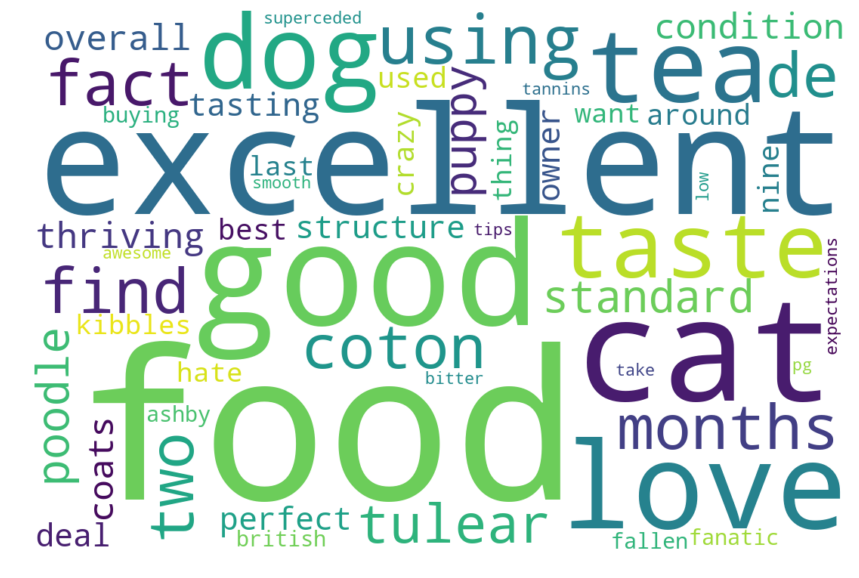

In [80]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster5), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(15,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [81]:
# Data-preprocessing: Normalizing Data

from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(sent_vectors)
print(standardized_data_train.shape)

(4986, 50)


In [82]:
# https://www.kaggle.com/vjchoudhary7/kmeans-clustering-in-customer-segmentation
#https://www.youtube.com/watch?v=TGad0nc-8gU
from sklearn.cluster import KMeans
k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i,init='k-means++',n_init=10, max_iter=300,tol=0.0001,precompute_distances='auto',verbose=0, random_state=42,n_jobs=-1)
    kmeans.fit(standardized_data_train)
    loss.append(kmeans.inertia_)
    
# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)
# save new clusters for chart

[[-5.19227968e-02  3.97427274e-02  1.24691677e-01 -2.97513113e-01
  -2.61106212e-01 -5.11739189e-03 -1.56461025e-02 -9.34512740e-02
   1.06568222e-01  2.42009773e-01 -8.71302315e-02  8.62212688e-02
  -1.27428797e-01 -1.92561389e-01  1.85156749e-01  8.22961459e-02
   4.21113026e-02 -3.32260780e-02  3.48742078e-02  1.59990452e-01
  -1.89585689e-01 -2.01561011e-01 -1.05840389e-01  6.68902286e-02
   1.16321552e-01 -9.94598597e-02  3.02380136e-02 -7.21673806e-02
   1.58591516e-01  2.09379727e-01 -1.03310316e-01 -1.38983925e-01
  -2.70672757e-02  1.70876399e-01  2.60520989e-01  7.23818795e-02
   1.31473659e-01  2.76115641e-02 -1.72914688e-01  2.04347697e-02
  -1.73999066e-01 -3.80087603e-01 -1.05151811e-01 -1.35825015e-02
   6.54648725e-05  7.07433079e-02  1.31033640e-01  1.14308975e-01
   4.87993602e-02 -8.45761349e-02]
 [-3.31041372e-02  1.98585129e-02  1.46589629e-01 -3.20268880e-01
  -2.91775208e-01  8.30519224e-03 -2.00575910e-02 -9.26051455e-02
   8.65132845e-02  2.34246500e-01 -7.4836

   5.45792532e-02 -6.21786369e-02]]


### Plotting a graph K vs  Inertia

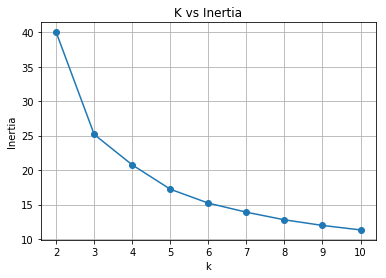

In [83]:
plt.plot(k_values,loss,marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title("K vs Inertia")
plt.grid()
plt.show()

In [84]:
kmeans = KMeans(n_clusters=3, init='k-means++',n_init=10, max_iter=300,tol=0.0001,precompute_distances='auto',verbose=0, random_state=42,n_jobs=-1)
kmeans.fit(standardized_data_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

### Getting all the Reviews in different clusters

In [85]:
reviews = preprocessed_reviews
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []


for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(reviews[i])
    else :
        cluster4.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))

No. of reviews in Cluster-1 :  2457

No. of reviews in Cluster-2 :  15

No. of reviews in Cluster-3 :  2514

No. of reviews in Cluster-4 :  0


### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

### Reading Reviews Manually:

In [86]:
# Three Reviews of cluster 1
reviews=[]
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    reviews.append(cluster1[i])
    count +=1
print(reviews)

Review-1 : 
 shipped day ordered arrived within days live opposite coast made order arrived nicely packaged price got lbs oz biscotti weighed kitchen scale cut big pieces add shipping handling comes little per piece approximately local bakery charges per biscotti guess going price homemade biscotti days flavor almondy hardness perfect biscotti hard crunchy not hard could not eat without dunking biscotti biscotti eaten dunked coffee tea cocoa dunked mine chai tea tastes great biscotti not fall apart dunked like almond flavor wish came anise flavor favorite biscotti flavor

Review-2 : 
 mix probably not something would want use everyday new enough different enough something special add summertime recipe want reward something fun fruity fill bill quickly easily no aftertaste often associated diet drinks highly recommend

Review-3 : 
 use keep finicky toddler protein levels great delicious way imagine cooking sausage favorite recipe sautee one large onion tablespoon dried basil oregano sal



Word Cloud for Important features


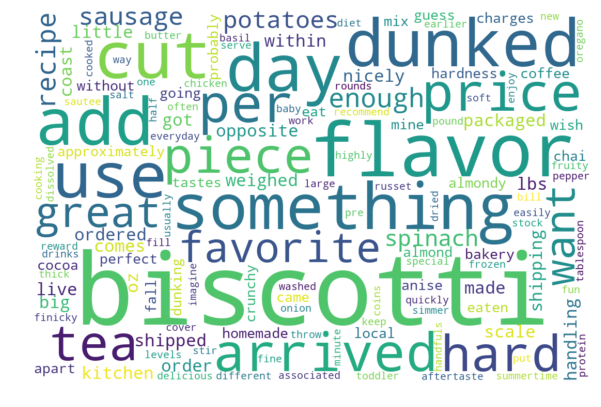

In [87]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster1), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(10,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [88]:
# Three Reviews of cluster 2
reviews=[]
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    reviews.append(cluster2[i])
    count +=1
print(reviews)

Review-1 : 
 

Review-2 : 
 

Review-3 : 
 

['', '', '']


In [89]:
# Here there are no reviews in clusters. for printing wordclouds we need atleast one word 

In [90]:
# Three Reviews of cluster 3
reviews=[]
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    reviews.append(cluster3[i])
    count +=1
print(reviews)

Review-1 : 
 product available victor traps unreal course total fly genocide pretty stinky right nearby

Review-2 : 
 used victor fly bait seasons ca not beat great product

Review-3 : 
 received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors

['product available victor traps unreal course total fly genocide pretty stinky right nearby', 'used victor fly bait seasons ca not beat great product', 'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors']




Word Cloud for Important features


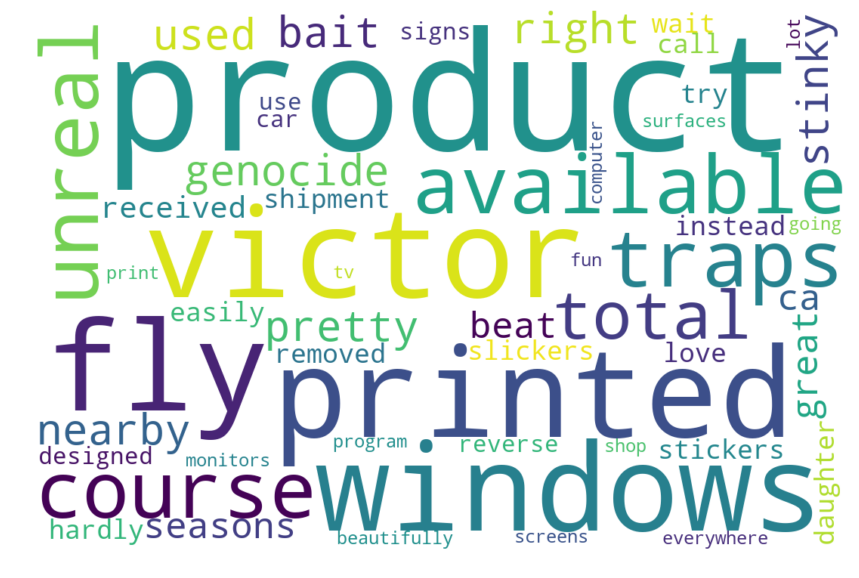

In [91]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster3), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(15,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [93]:
# Data-preprocessing: Normalizing Data
from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(tfidf_sent_vectors)
print(standardized_data_train.shape)


(4986, 50)


In [94]:
# https://www.kaggle.com/vjchoudhary7/kmeans-clustering-in-customer-segmentation
#https://www.youtube.com/watch?v=TGad0nc-8gU
from sklearn.cluster import KMeans
k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i,init='k-means++',n_init=10, max_iter=300,tol=0.0001,precompute_distances='auto',verbose=0, random_state=42,n_jobs=-1)
    kmeans.fit(standardized_data_train)
    loss.append(kmeans.inertia_)
    
# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)
# save new clusters for chart

[[-4.11917665e-02  5.12285445e-02  1.45419797e-01 -3.12431012e-01
  -2.54729667e-01 -4.30602876e-03 -2.23108273e-02 -8.93500108e-02
   1.10232082e-01  2.46627762e-01 -9.72544886e-02  8.20680177e-02
  -1.32899350e-01 -1.89748872e-01  1.65069356e-01  8.96482745e-02
   5.94200171e-02 -3.49616750e-02  4.33631323e-02  1.68171335e-01
  -1.92223903e-01 -1.90346000e-01 -1.01861412e-01  6.03261391e-02
   1.10915620e-01 -1.12411481e-01  8.24211940e-03 -6.15850536e-02
   1.71322464e-01  1.93582130e-01 -1.04076950e-01 -1.32935520e-01
  -1.12293823e-02  1.67506401e-01  2.76573957e-01  9.17688877e-02
   1.28677804e-01  3.29457453e-02 -1.58685549e-01  2.57510679e-02
  -1.65671570e-01 -3.75857479e-01 -9.09522482e-02 -3.39398087e-03
  -3.93553238e-03  8.26607124e-02  1.29166189e-01  1.10090280e-01
   5.17367169e-02 -6.38458614e-02]
 [-5.64418199e-02  1.48138564e-02  9.73529978e-02 -2.97671885e-01
  -2.52980972e-01 -2.20362603e-02 -1.78485117e-02 -1.13093947e-01
   8.14895899e-02  2.13554382e-01 -6.3391

   7.21084712e-02 -2.42581913e-02]]


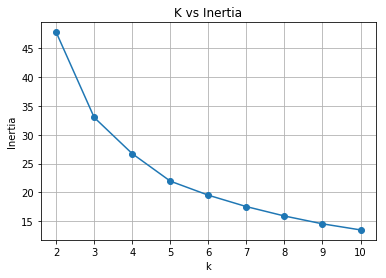

In [95]:
## Plotting a graph K vs  Inertia

plt.plot(k_values,loss,marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title("K vs Inertia")
plt.grid()
plt.show()

In [96]:
kmeans = KMeans(n_clusters=3, init='k-means++',n_init=10, max_iter=300,tol=0.0001,precompute_distances='auto',verbose=0, random_state=42,n_jobs=-1)
kmeans.fit(standardized_data_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

### Getting all the Reviews in different clusters

In [97]:
reviews = preprocessed_reviews
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []


for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(reviews[i])
    else :
        cluster3.append(reviews[i]) 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))


No. of reviews in Cluster-1 :  2066

No. of reviews in Cluster-2 :  2905

No. of reviews in Cluster-3 :  15


### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

###  Reading Reviews Manually:

In [98]:
# Three Reviews of cluster 1
reviews=[]
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    reviews.append(cluster1[i])
    count +=1
print(reviews)

Review-1 : 
 shipped day ordered arrived within days live opposite coast made order arrived nicely packaged price got lbs oz biscotti weighed kitchen scale cut big pieces add shipping handling comes little per piece approximately local bakery charges per biscotti guess going price homemade biscotti days flavor almondy hardness perfect biscotti hard crunchy not hard could not eat without dunking biscotti biscotti eaten dunked coffee tea cocoa dunked mine chai tea tastes great biscotti not fall apart dunked like almond flavor wish came anise flavor favorite biscotti flavor

Review-2 : 
 use keep finicky toddler protein levels great delicious way imagine cooking sausage favorite recipe sautee one large onion tablespoon dried basil oregano salt pepper butter add sausage cut coins russet potatoes cut thick rounds cover chicken stock simmer potatoes soft not dissolved throw handfuls pre washed baby spinach usually use half pound frozen would work fine put minute earlier stir spinach cooked s



Word Cloud for Important features


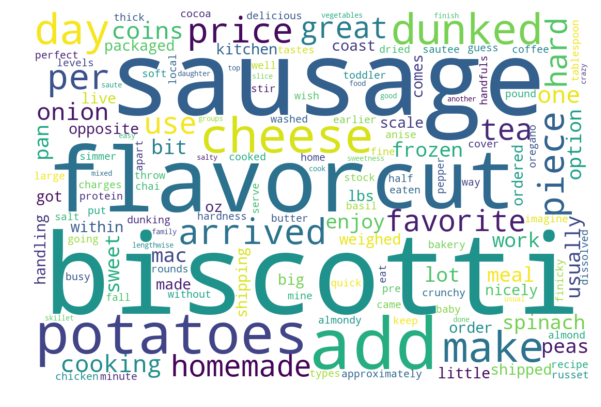

In [99]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster1), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(10,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [100]:
# Three Reviews of cluster 2
reviews=[]
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster2[i]))
    reviews.append(cluster2[i])
    count +=1
print(reviews)

Review-1 : 
 product available victor traps unreal course total fly genocide pretty stinky right nearby

Review-2 : 
 used victor fly bait seasons ca not beat great product

Review-3 : 
 received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors

['product available victor traps unreal course total fly genocide pretty stinky right nearby', 'used victor fly bait seasons ca not beat great product', 'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors']




Word Cloud for Important features


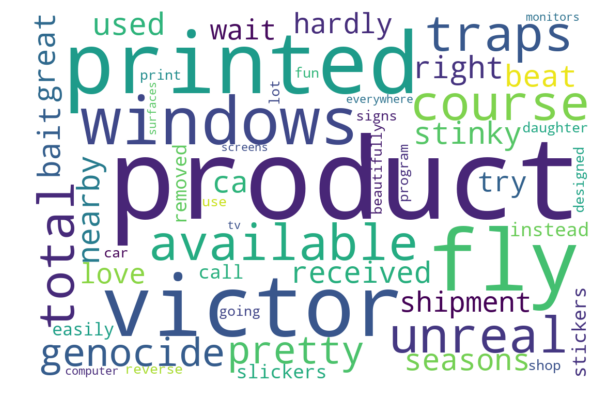

In [101]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster2), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(10,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [102]:
# Three Reviews of cluster 3
reviews=[]
count=1
for i in range(15):
    print('Review-%d : \n %s\n'%(count,cluster3[i]))
    reviews.append(cluster3[i])
    count +=1
print(reviews)

Review-1 : 
 

Review-2 : 
 

Review-3 : 
 

Review-4 : 
 

Review-5 : 
 

Review-6 : 
 

Review-7 : 
 

Review-8 : 
 

Review-9 : 
 

Review-10 : 
 

Review-11 : 
 

Review-12 : 
 

Review-13 : 
 

Review-14 : 
 

Review-15 : 
 

['', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


In [103]:
# Here there are no reviews in clusters. for printing wordclouds we need atleast one word 

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [104]:
# Data-preprocessing: Normalizing Data

from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(sent_vectors)
print(standardized_data_train.shape)

from sklearn.cluster import AgglomerativeClustering

standardized_data_train=standardized_data_train[0:5000] #Normalizing and taking 5000 reviews

(4986, 50)


In [105]:
model = AgglomerativeClustering(n_clusters=2).fit(standardized_data_train)
model.labels_

reviews = preprocessed_reviews          
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  4971

No. of reviews in Cluster-2 :  15


### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

### Reading Reviews Manually:


In [106]:
# Three Reviews of cluster 1
reviews=[]
count=1
for i in range(3):
    if i < len(cluster1):
        print('Review-%d : \n %s\n'%(count,cluster1[i]))
        reviews.append(cluster1[i])
        count +=1
print(reviews)

Review-1 : 
 product available victor traps unreal course total fly genocide pretty stinky right nearby

Review-2 : 
 used victor fly bait seasons ca not beat great product

Review-3 : 
 received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors

['product available victor traps unreal course total fly genocide pretty stinky right nearby', 'used victor fly bait seasons ca not beat great product', 'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors']




Word Cloud for Important features


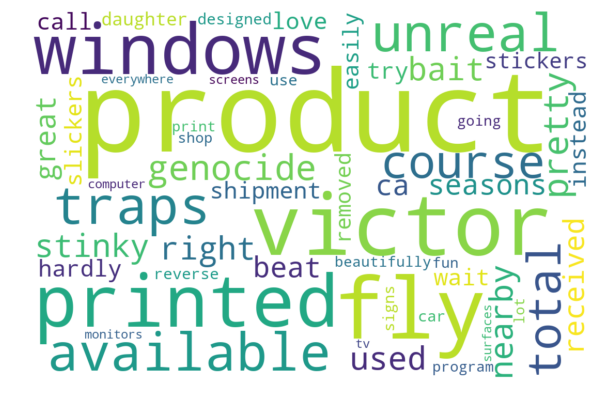

In [107]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster1), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(10,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [108]:
# Three Reviews of cluster 2
reviews=[]
count=1
for i in range(3):
    if i < len(cluster2):
        print('Review-%d : \n %s\n'%(count,cluster2[i]))
        reviews.append(cluster2[i])
        count +=1
print(reviews)

Review-1 : 
 

Review-2 : 
 

Review-3 : 
 

['', '', '']


In [110]:
# Here there are no reviews in clusters. for printing wordclouds we need atleast one word 

### Applying AgglomerativeClustering Algorithm with n_clusters=5


In [111]:
from sklearn.cluster import AgglomerativeClustering

standardized_data_train=standardized_data_train[0:5000]
#standardized_data_test=standardized_data_test[0:5000]

model = AgglomerativeClustering(n_clusters=5,linkage='ward',affinity='euclidean')
model.fit(standardized_data_train)
model.labels_

array([0, 1, 1, ..., 2, 2, 2], dtype=int64)

In [112]:
reviews = preprocessed_reviews
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []


for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])

# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))


No. of reviews in Cluster-1 :  1183

No. of reviews in Cluster-2 :  3803


### Reading Reviews Manually

In [113]:
# Three Reviews of cluster 1
reviews=[]
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    reviews.append(cluster1[i])
    count +=1
print(reviews)

Review-1 : 
 product available victor traps unreal course total fly genocide pretty stinky right nearby

Review-2 : 
 glad cocker standard poodle puppy loves stuff trust brand superior nutrition compare labels previous feed pedigree mostly corn little dude healthy happy high energy glossy coat also superior nutrition produces smaller compact stools

Review-3 : 
 using food months find excellent fact two dogs coton de tulear standard poodle puppy love food thriving coats excellent condition overall structure perfect good tasting dog good good deal owner around best food ever used excellent

['product available victor traps unreal course total fly genocide pretty stinky right nearby', 'glad cocker standard poodle puppy loves stuff trust brand superior nutrition compare labels previous feed pedigree mostly corn little dude healthy happy high energy glossy coat also superior nutrition produces smaller compact stools', 'using food months find excellent fact two dogs coton de tulear standard



Word Cloud for Important features


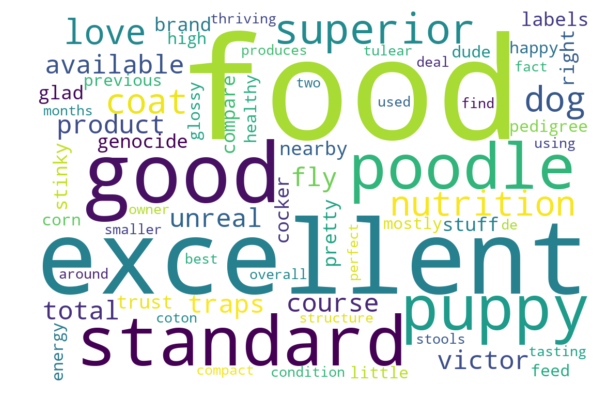

In [114]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster1), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(10,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [115]:
# Three Reviews of cluster 2
reviews=[]
count=1
for i in range(3):
    if i < len(cluster2):
        print('Review-%d : \n %s\n'%(count,cluster2[i]))
        reviews.append(cluster2[i])
        count +=1
print(reviews)

Review-1 : 
 used victor fly bait seasons ca not beat great product

Review-2 : 
 received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors

Review-3 : 
 really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs

['used victor fly bait seasons ca not beat great product', 'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors', 'really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs']




Word Cloud for Important features


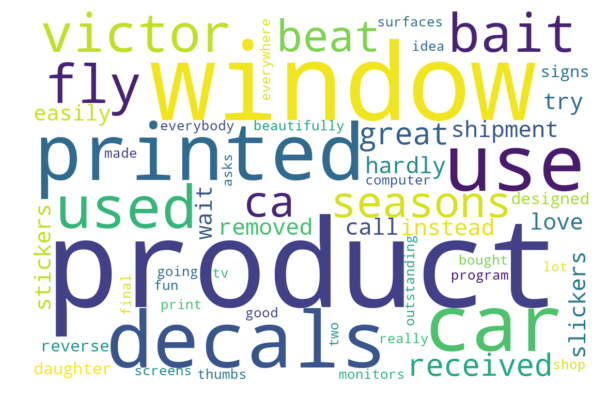

In [116]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster2), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(10,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [117]:
# Data-preprocessing: Normalizing Data

from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(tfidf_sent_vectors)
print(standardized_data_train.shape)

from sklearn.cluster import AgglomerativeClustering

standardized_data_train=standardized_data_train[0:5000]

(4986, 50)


In [118]:
model = AgglomerativeClustering(n_clusters=2).fit(standardized_data_train)
model.labels_

reviews = preprocessed_reviews          
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []

for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  2789

No. of reviews in Cluster-2 :  2197


In [119]:
# Three Reviews of cluster 1
reviews=[]
count=1
for i in range(3):
    if i < len(cluster1):
        print('Review-%d : \n %s\n'%(count,cluster1[i]))
        reviews.append(cluster1[i])
        count +=1
print(reviews)

Review-1 : 
 product available victor traps unreal course total fly genocide pretty stinky right nearby

Review-2 : 
 used victor fly bait seasons ca not beat great product

Review-3 : 
 received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors

['product available victor traps unreal course total fly genocide pretty stinky right nearby', 'used victor fly bait seasons ca not beat great product', 'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors']


### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>



Word Cloud for Important features


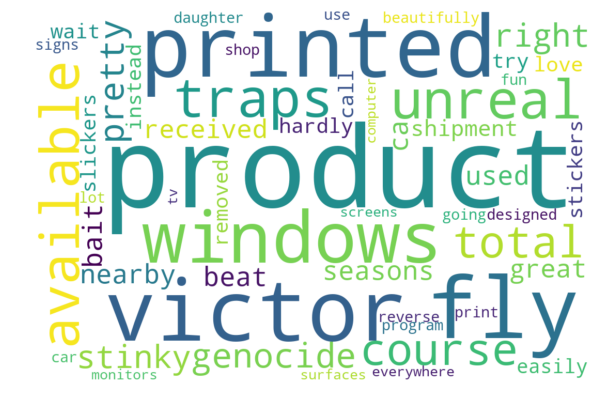

In [120]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster1), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(10,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [121]:
# Three Reviews of cluster 2
reviews=[]
count=1
for i in range(3):
    if i < len(cluster2):
        print('Review-%d : \n %s\n'%(count,cluster2[i]))
        reviews.append(cluster2[i])
        count +=1
print(reviews)

Review-1 : 
 shipped day ordered arrived within days live opposite coast made order arrived nicely packaged price got lbs oz biscotti weighed kitchen scale cut big pieces add shipping handling comes little per piece approximately local bakery charges per biscotti guess going price homemade biscotti days flavor almondy hardness perfect biscotti hard crunchy not hard could not eat without dunking biscotti biscotti eaten dunked coffee tea cocoa dunked mine chai tea tastes great biscotti not fall apart dunked like almond flavor wish came anise flavor favorite biscotti flavor

Review-2 : 
 mix probably not something would want use everyday new enough different enough something special add summertime recipe want reward something fun fruity fill bill quickly easily no aftertaste often associated diet drinks highly recommend

Review-3 : 
 bought brand online indian grocery store usually excellent products able turn cream butter using super blender adding water barely flavor usually buy chao ka



Word Cloud for Important features


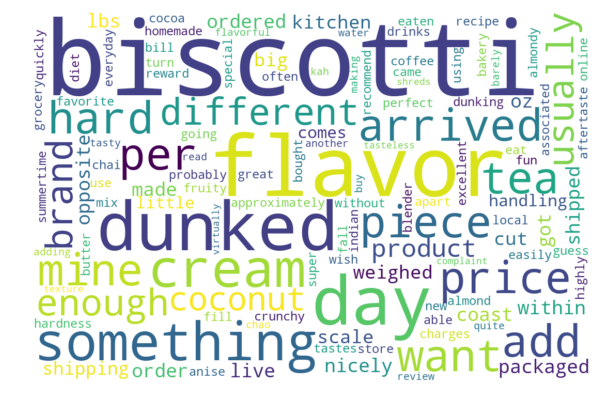

In [122]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster2), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(10,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Applying AgglomerativeClustering Algorithm with n_clusters=5


In [123]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=5,linkage='ward',affinity='euclidean')
model.fit(standardized_data_train)
model.labels_

array([0, 0, 0, ..., 3, 3, 3], dtype=int64)

In [124]:
reviews = preprocessed_reviews
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif model.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif model.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif model.labels_[i] == 3:
        cluster4.append(reviews[i])
    else :
        cluster5.append(reviews[i])

# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))
print("\nNo. of reviews in Cluster-3 : ",len(cluster3))
print("\nNo. of reviews in Cluster-4 : ",len(cluster4))
print("\nNo. of reviews in Cluster-5 : ",len(cluster5))

No. of reviews in Cluster-1 :  2327

No. of reviews in Cluster-2 :  447

No. of reviews in Cluster-3 :  15

No. of reviews in Cluster-4 :  1738

No. of reviews in Cluster-5 :  459


### Reading Reviews Manually:

In [125]:
# Three Reviews of cluster 1
reviews=[]
count=1
for i in range(3):
    print('Review-%d : \n %s\n'%(count,cluster1[i]))
    reviews.append(cluster1[i])
    count +=1
print(reviews)

Review-1 : 
 product available victor traps unreal course total fly genocide pretty stinky right nearby

Review-2 : 
 used victor fly bait seasons ca not beat great product

Review-3 : 
 received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors

['product available victor traps unreal course total fly genocide pretty stinky right nearby', 'used victor fly bait seasons ca not beat great product', 'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors']




Word Cloud for Important features


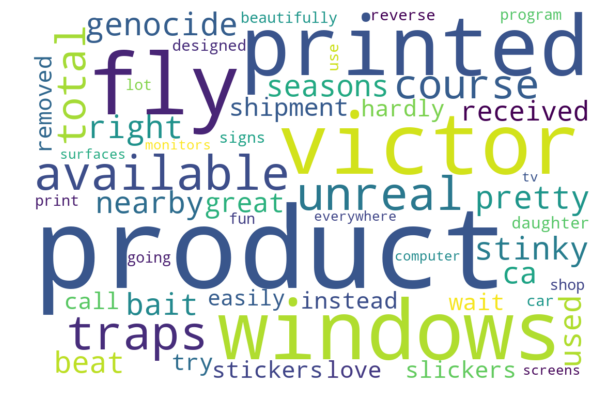

In [126]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster1), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(10,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [127]:
# Three Reviews of cluster 2
reviews=[]
count=1
for i in range(3):
    if i < len(cluster2):
        print('Review-%d : \n %s\n'%(count,cluster2[i]))
        reviews.append(cluster2[i])
        count +=1
print(reviews)

Review-1 : 
 five minutes one tentacle bitten ball inside cracked half not durable enough dog toy disappointed dog

Review-2 : 
 review make sound really stupid whatever not really care long people find real avoid mistakes got wonderful little sweet bella bean days shy three years old bounced around house house eating whatever cheap cats around entire life twenty five years mother always fed whatever kinds food buy supermarket friskies nine lives kit kaboodle stuff like cats always fine least terms eating habits would eat morning stop done come back eat got hungry housemate time working hill assured best food ever made great forth know utter buffoon initially trusted judgment unfortunate not think also plenty coupons free deeply discounted bags made much attractive choice first tried feeding little bean unmeasured amount science diet bowl not work would devour one sitting took measuring thing started parsing twice day not work either would start going crazy middle day running around in



Word Cloud for Important features


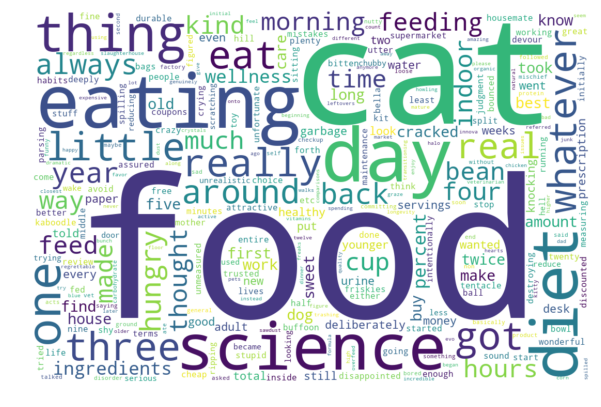

In [128]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster2), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(10,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [129]:
# Three Reviews of cluster 3
reviews=[]
count=1
for i in range(3):
    if i < len(cluster3):
        print('Review-%d : \n %s\n'%(count,cluster3[i]))
        reviews.append(cluster3[i])
        count +=1
print(reviews)

Review-1 : 
 

Review-2 : 
 

Review-3 : 
 

['', '', '']


In [130]:
# Here there are no reviews in clusters. for printing wordclouds we need atleast one word 

In [131]:
# Three Reviews of cluster 4
reviews=[]
count=1
for i in range(3):
    if i < len(cluster4):
        print('Review-%d : \n %s\n'%(count,cluster4[i]))
        reviews.append(cluster4[i])
        count +=1
print(reviews)

Review-1 : 
 shipped day ordered arrived within days live opposite coast made order arrived nicely packaged price got lbs oz biscotti weighed kitchen scale cut big pieces add shipping handling comes little per piece approximately local bakery charges per biscotti guess going price homemade biscotti days flavor almondy hardness perfect biscotti hard crunchy not hard could not eat without dunking biscotti biscotti eaten dunked coffee tea cocoa dunked mine chai tea tastes great biscotti not fall apart dunked like almond flavor wish came anise flavor favorite biscotti flavor

Review-2 : 
 mix probably not something would want use everyday new enough different enough something special add summertime recipe want reward something fun fruity fill bill quickly easily no aftertaste often associated diet drinks highly recommend

Review-3 : 
 bought brand online indian grocery store usually excellent products able turn cream butter using super blender adding water barely flavor usually buy chao ka



Word Cloud for Important features


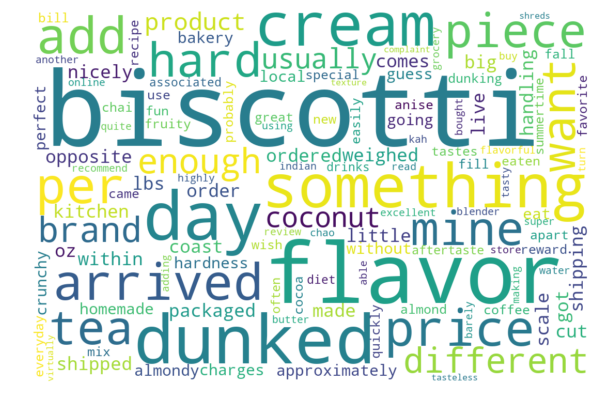

In [132]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster4), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(10,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [133]:
# Three Reviews of cluster 5
reviews=[]
count=1
for i in range(3):
    if i < len(cluster5):
        print('Review-%d : \n %s\n'%(count,cluster5[i]))
        reviews.append(cluster5[i])
        count +=1
print(reviews)

Review-1 : 
 not good yummy smell like cloves cooking taste little sweet

Review-2 : 
 best sweet chili sauce found anywhere say sweet hey sweet chili sauce supposed sweet rich full flavor everyone family likes even wife not stand anything anyone would consider hot loves sauce pepper head like like little kick try adding sriracha hot chili sauce learn love

Review-3 : 
 fallen love tea british tea fanatic ashby superceded tastes expectations smooth not bitter low tannins awesome taste take pg tips

['not good yummy smell like cloves cooking taste little sweet', 'best sweet chili sauce found anywhere say sweet hey sweet chili sauce supposed sweet rich full flavor everyone family likes even wife not stand anything anyone would consider hot loves sauce pepper head like like little kick try adding sriracha hot chili sauce learn love', 'fallen love tea british tea fanatic ashby superceded tastes expectations smooth not bitter low tannins awesome taste take pg tips']




Word Cloud for Important features


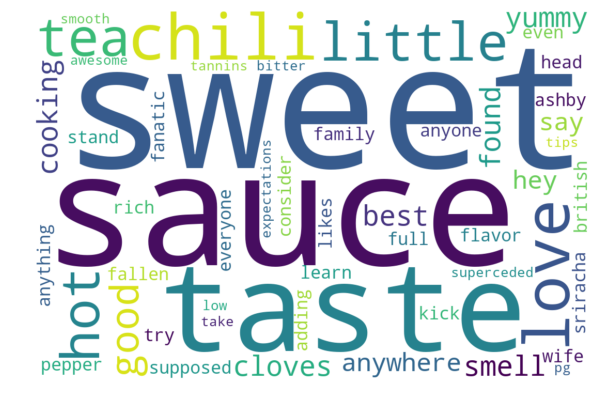

In [134]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster5), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(10,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [135]:
# Data-preprocessing: Normalizing Data

from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(sent_vectors)
standardized_data_train=standardized_data_train[0:5000]
print(standardized_data_train.shape)

(4986, 50)


### Function To Compute Distance of nth-nearest neighbour


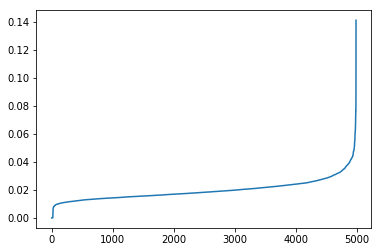

In [136]:
#https://www.youtube.com/redirect?redir_token=enbfECV2VvY4YDA1msCth3UWIBN8MTU0NjI0NTU4MEAxNTQ2MTU5MTgw&q=http%3A%2F%2Fiopscience
from sklearn.neighbors import NearestNeighbors

nbrs=NearestNeighbors(n_neighbors=3,algorithm='brute').fit(standardized_data_train)
distances,indices=nbrs.kneighbors(standardized_data_train)
distances=np.sort(distances,axis=0)
distances=distances[:,1]
plt.plot(distances)
plt.show()

In [137]:
eps=0.03
db = DBSCAN(eps=0.03, min_samples=10).fit(standardized_data_train)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("With EPS value of {}, we have total of {}".format(eps,n_clusters_))


With EPS value of 0.03, we have total of 2


In [138]:
eps=0.3
db = DBSCAN(eps=0.3, min_samples=10).fit(standardized_data_train)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("With EPS value of {}, we have total of {}".format(eps,n_clusters_))


With EPS value of 0.3, we have total of 2


In [139]:
from sklearn.cluster import DBSCAN
eps=0.8
db = DBSCAN(eps=0.8, min_samples=10).fit(standardized_data_train)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("With EPS value of {}, we have total of {} clusters".format(eps,n_clusters_))

With EPS value of 0.8, we have total of 2 clusters


In [140]:
eps=0.9
db = DBSCAN(eps=0.9, min_samples=10).fit(standardized_data_train)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("With EPS value of {}, we have total of {} clusters".format(eps,n_clusters_))

With EPS value of 0.9, we have total of 2 clusters


In [141]:
eps=1
db = DBSCAN(eps=1, min_samples=10).fit(standardized_data_train)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("With EPS value of {}, we have total of {} clusters".format(eps,n_clusters_))

With EPS value of 1, we have total of 1 clusters


In [142]:
eps=1.1
db = DBSCAN(eps=1.1, min_samples=10).fit(standardized_data_train)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("With EPS value of {}, we have total of {}".format(eps,n_clusters_))


With EPS value of 1.1, we have total of 1


In [143]:
reviews = preprocessed_reviews  
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
db = DBSCAN(eps=0.03, min_samples=10).fit(standardized_data_train)
for i in range(db.labels_.shape[0]):
    if db.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  4269

No. of reviews in Cluster-2 :  717


In [144]:
# Three Reviews of cluster 1
reviews=[]
count=1
for i in range(3):
    if i < len(cluster1):
        print('Review-%d : \n %s\n'%(count,cluster1[i]))
        reviews.append(cluster1[i])
        count +=1
print(reviews)

Review-1 : 
 product available victor traps unreal course total fly genocide pretty stinky right nearby

Review-2 : 
 used victor fly bait seasons ca not beat great product

Review-3 : 
 received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors

['product available victor traps unreal course total fly genocide pretty stinky right nearby', 'used victor fly bait seasons ca not beat great product', 'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors']


### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>



Word Cloud for Important features


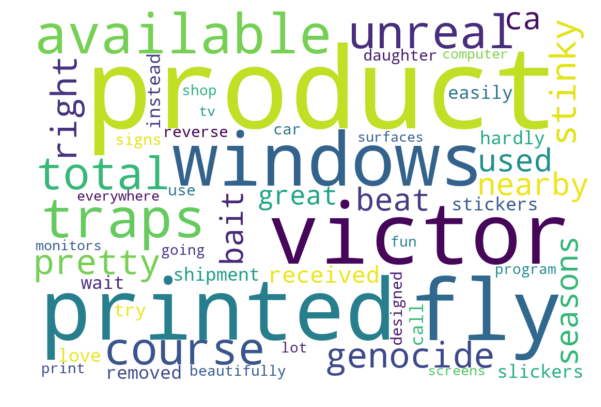

In [145]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster1), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(10,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [146]:
# Data-preprocessing: Normalizing Data

from sklearn import preprocessing
standardized_data_train = preprocessing.normalize(tfidf_sent_vectors)
standardized_data_train=standardized_data_train[0:5000]
print(standardized_data_train.shape)

(4986, 50)


### Function To Compute Distance of nth-nearest neighbour

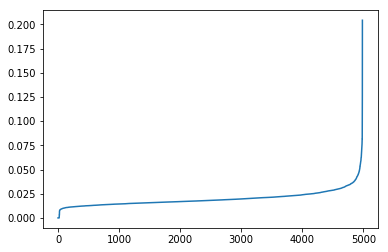

In [147]:
#https://www.youtube.com/redirect?redir_token=enbfECV2VvY4YDA1msCth3UWIBN8MTU0NjI0NTU4MEAxNTQ2MTU5MTgw&q=http%3A%2F%2Fiopscience
from sklearn.neighbors import NearestNeighbors

nbrs=NearestNeighbors(n_neighbors=3,algorithm='brute').fit(standardized_data_train)
distances,indices=nbrs.kneighbors(standardized_data_train)
distances=np.sort(distances,axis=0)
distances=distances[:,1]
plt.plot(distances)
plt.show()

In [157]:
from sklearn.cluster import DBSCAN
eps=0.02
db = DBSCAN(eps=0.02, min_samples=10).fit(standardized_data_train)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("With EPS value of {}, we have total of {} clusters".format(eps,n_clusters_))

With EPS value of 0.02, we have total of 6 clusters


In [148]:
from sklearn.cluster import DBSCAN
eps=0.2
db = DBSCAN(eps=0.2, min_samples=10).fit(standardized_data_train)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("With EPS value of {}, we have total of {} clusters".format(eps,n_clusters_))

With EPS value of 0.2, we have total of 2 clusters


In [149]:
eps=0.3
db = DBSCAN(eps=0.3, min_samples=10).fit(standardized_data_train)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("With EPS value of {}, we have total of {} clusters".format(eps,n_clusters_))

With EPS value of 0.3, we have total of 2 clusters


In [150]:
eps=0.8
db = DBSCAN(eps=0.8, min_samples=10).fit(standardized_data_train)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("With EPS value of {}, we have total of {} clusters".format(eps,n_clusters_))

With EPS value of 0.8, we have total of 2 clusters


In [151]:
eps=1.1
db = DBSCAN(eps=1.1, min_samples=10).fit(standardized_data_train)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print("With EPS value of {}, we have total of {}".format(eps,n_clusters_))


With EPS value of 1.1, we have total of 1


### Reading Reviews Manually

In [152]:
reviews = preprocessed_reviews
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
db = DBSCAN(eps=0.02, min_samples=10).fit(standardized_data_train)
for i in range(db.labels_.shape[0]):
    if db.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 
        
# Number of reviews in different clusters
print("No. of reviews in Cluster-1 : ",len(cluster1))
print("\nNo. of reviews in Cluster-2 : ",len(cluster2))

No. of reviews in Cluster-1 :  1885

No. of reviews in Cluster-2 :  3101


In [153]:
# Three Reviews of cluster 1
reviews=[]
count=1
for i in range(3):
    if i < len(cluster1):
        print('Review-%d : \n %s\n'%(count,cluster1[i]))
        reviews.append(cluster1[i])
        count +=1
print(reviews)

Review-1 : 
 product available victor traps unreal course total fly genocide pretty stinky right nearby

Review-2 : 
 received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors

Review-3 : 
 really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs

['product available victor traps unreal course total fly genocide pretty stinky right nearby', 'received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors', 'really good idea final product outstanding use decals car window everybody asks bought decals made two

### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>



Word Cloud for Important features


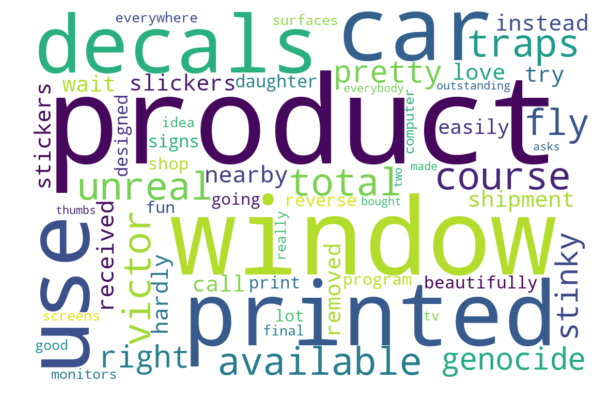

In [154]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster1), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(10,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [155]:
# Three Reviews of cluster 2
reviews=[]
count=1
for i in range(3):
    if i < len(cluster2):
        print('Review-%d : \n %s\n'%(count,cluster2[i]))
        reviews.append(cluster2[i])
        count +=1
print(reviews)

Review-1 : 
 used victor fly bait seasons ca not beat great product

Review-2 : 
 using food months find excellent fact two dogs coton de tulear standard poodle puppy love food thriving coats excellent condition overall structure perfect good tasting dog good good deal owner around best food ever used excellent

Review-3 : 
 nine cats crazy kibbles last thing want cat food cats hate buying

['used victor fly bait seasons ca not beat great product', 'using food months find excellent fact two dogs coton de tulear standard poodle puppy love food thriving coats excellent condition overall structure perfect good tasting dog good good deal owner around best food ever used excellent', 'nine cats crazy kibbles last thing want cat food cats hate buying']




Word Cloud for Important features


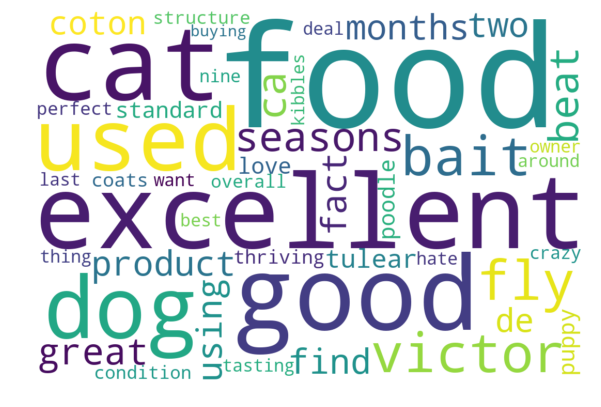

In [156]:
from wordcloud import WordCloud 

list_of_words_str = ' '.join(reviews)

wc = WordCloud(background_color="white", max_words=len(cluster1), 
               width=1080, height=720,min_font_size = 10, collocations=False)
wc.generate(list_of_words_str)
plt.figure(figsize=(10,10))
print ("\n\nWord Cloud for Important features")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# [6] Conclusions

In [159]:
from prettytable import PrettyTable
print("\n Model performance table of k-means")    
x = PrettyTable()

x.field_names=["Model","kvalue","Reviews in cluster1","cluster2","cluster3","Reviews in cluster4","Reviews in cluster5"]

x.add_row(["K-means with Bow",  5,1487,309,412,1985,820])
x.add_row(["K-means with Bow(bi-grams)",  5,427,2208,1750,304,297])
x.add_row(["K-means with tf-idf", 5,3379,570,0,0,1037])
x.add_row(["K-means with Avgword2vec", 3,2457,15,2514,0,0])
x.add_row(["K-means with tfidfw2vec", 3,2066,2905,15,0,0])
print(x)


from prettytable import PrettyTable
print("\n Model performance table of Agglomerative clustering")    
x = PrettyTable()

x.field_names = ["Model","n_clusters","Reviews in cluster1","cluster2","cluster3","cluster4","cluster5"]

x.add_row(["Agglomerative clustering with Avgword2vec",2, 4971,15,0,0,0])
x.add_row(["Agglomerative clustering with Avgword2vec",5, 1183,3803,0,0,0])
x.add_row(["Agglomeratiive clustering with tfidfw2vec",2,2789,2197,0,0,0])
x.add_row(["Agglomeratiive clustering with tfidfw2vec",5,2327,447,15,1738,459])
print(x)



from prettytable import PrettyTable
print("\n Model performance table of db-scan")    
x = PrettyTable()

x.field_names = ["Model","epsilon", "Total no of clusters"]

x.add_row(["Dbscan with Avgword2vec", 0.03,2])
x.add_row(["Dbscan with Avgword2vec", 0.3,2])
x.add_row(["Dbscan with Avgword2vec", 0.8,2])
x.add_row(["Dbscan with Avgword2vec", 0.9,2])
x.add_row(["Dbscan with Avgword2vec", 1,1])
x.add_row(["Dbscan with Avgword2vec", 1.1,1])
x.add_row(["Dbscan with tfidfw2vec", 0.2,2])
x.add_row(["Dbscan with tfidfw2vec", 0.3,2])
x.add_row(["Dbscan with tfidfw2vec", 0.8,2])
x.add_row(["Dbscan with tfidfw2vec", 1.1,1])
print(x)

from prettytable import PrettyTable
print("\n Model performance table of db-scan")    
x = PrettyTable()

x.field_names = ["Model","epsilon", "Total no of clusters","Reviews in cluster-1","Reviews in cluster-2"]

x.add_row(["Dbscan with Avgword2vec", 0.03,2,4269,717])
x.add_row(["Dbscan with tfidfw2vec", 0.02,6,1885,3101])
print(x)



 Model performance table of k-means
+----------------------------+--------+---------------------+----------+----------+---------------------+---------------------+
|           Model            | kvalue | Reviews in cluster1 | cluster2 | cluster3 | Reviews in cluster4 | Reviews in cluster5 |
+----------------------------+--------+---------------------+----------+----------+---------------------+---------------------+
|      K-means with Bow      |   5    |         1487        |   309    |   412    |         1985        |         820         |
| K-means with Bow(bi-grams) |   5    |         427         |   2208   |   1750   |         304         |         297         |
|    K-means with tf-idf     |   5    |         3379        |   570    |    0     |          0          |         1037        |
|  K-means with Avgword2vec  |   3    |         2457        |    15    |   2514   |          0          |          0          |
|  K-means with tfidfw2vec   |   3    |         2066        |   290